In [31]:
# Install necessary packages
!pip install xgboost lightgbm

In [32]:
# Importing Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

In [3]:
# Load the Titanic dataset
train_data = pd.read_csv("Titanic_train.csv")
test_data = pd.read_csv("Titanic_test.csv")

In [33]:
# EDA
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    int32  
 3   Age       891 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  891 non-null    int32  
dtypes: float64(2), int32(2), int64(4)
memory usage: 48.9 KB


In [34]:
train_data.describe()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,0.647587,29.699118,0.523008,0.381594,2.962246,1.536476
std,0.486592,0.836071,0.477990,13.002015,1.102743,0.806057,0.969048,0.791503
min,0.000000,1.000000,0.000000,0.420000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,22.000000,0.000000,0.000000,2.187218,1.000000
50%,0.000000,3.000000,1.000000,29.699118,0.000000,0.000000,2.737881,2.000000
75%,1.000000,3.000000,1.000000,35.000000,1.000000,0.000000,3.465736,2.000000
max,1.000000,3.000000,1.000000,80.000000,8.000000,6.000000,6.240917,2.000000


In [5]:
# Numeric and Categorical features
df_num = train_data[["Age", "SibSp", "Parch", "Fare"]]
df_cat = train_data[["Survived", "Sex", "Cabin", "Embarked", "Ticket"]]

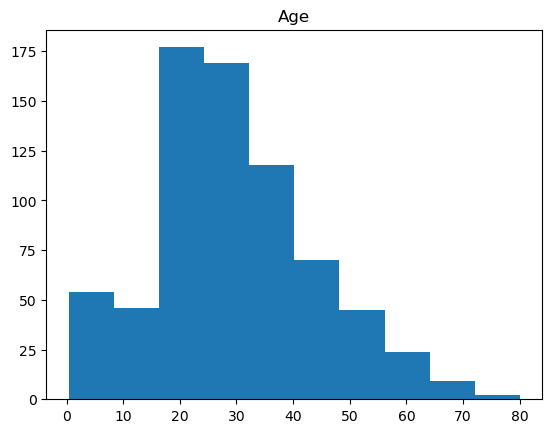

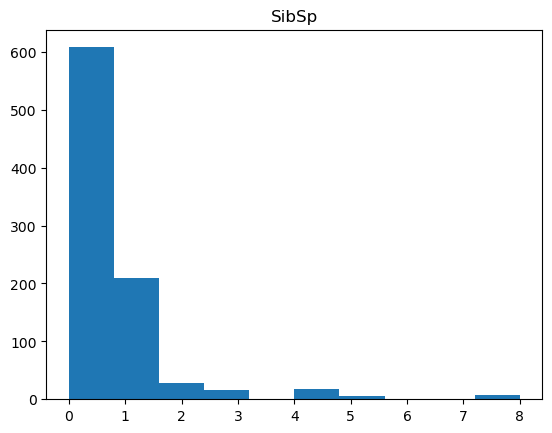

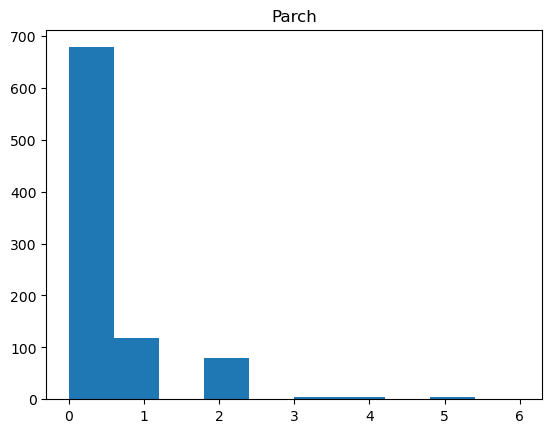

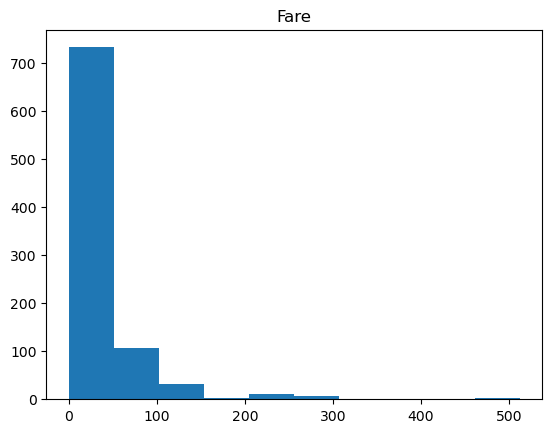

In [6]:
# Histograms for numeric data distribution
for i in df_num.columns:
    plt.hist(df_num[i])
    plt.title(i)
    plt.show()

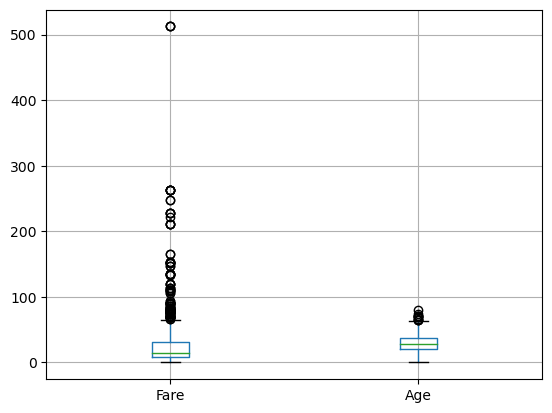

In [7]:
# Boxplots for numeric data
train_data[['Fare', 'Age']].boxplot()
plt.show()

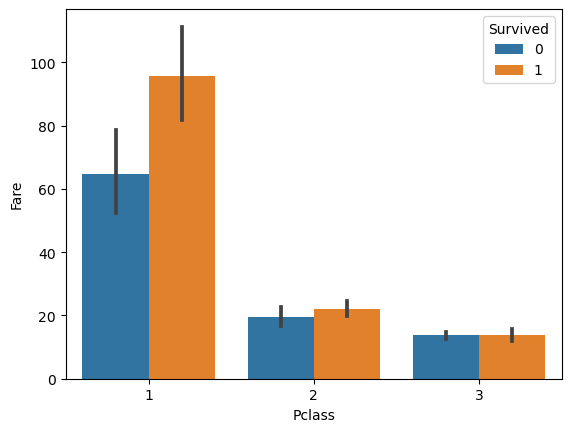

In [8]:
# Bar plot for Pclass vs Fare with survival
sns.barplot(data=train_data, x="Pclass", y="Fare", hue="Survived")
plt.show()

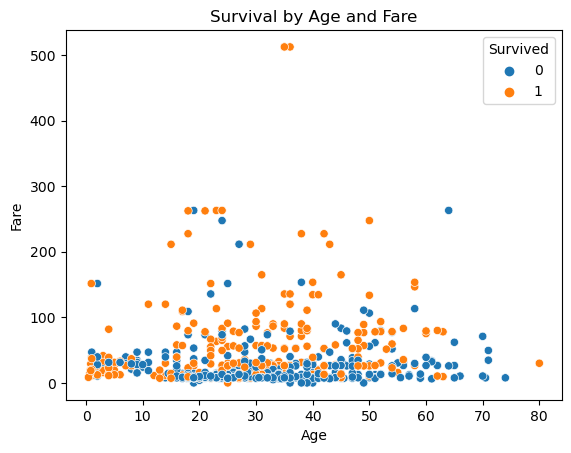

In [9]:
# Scatter plot for Age vs Fare with survival
sns.scatterplot(x='Age', y='Fare', hue='Survived', data=train_data)
plt.title("Survival by Age and Fare")
plt.show()


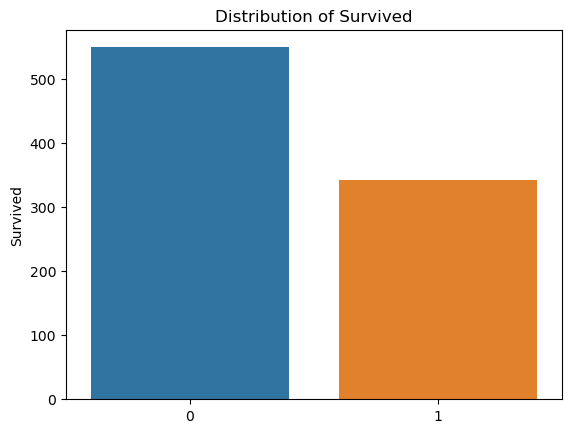

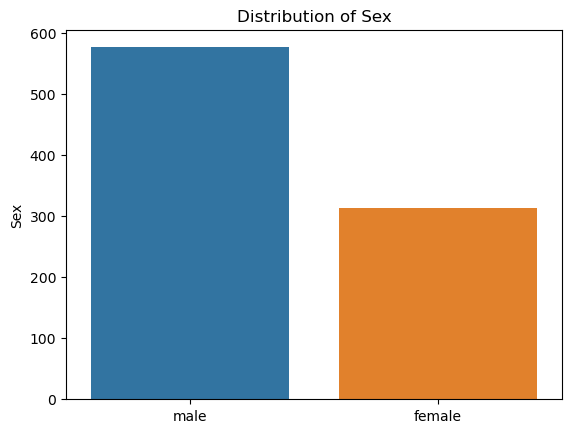

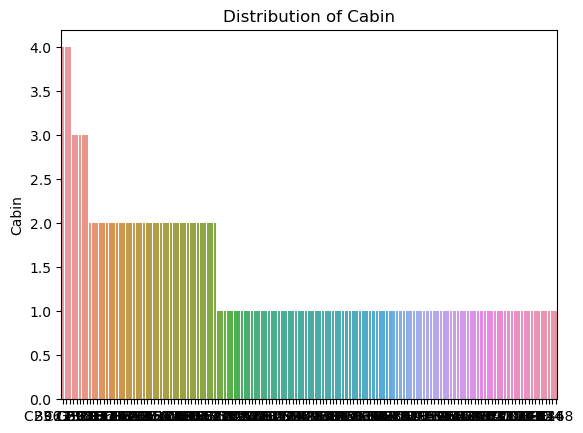

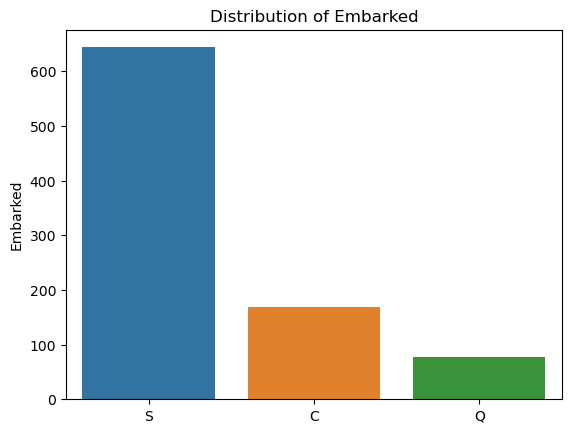

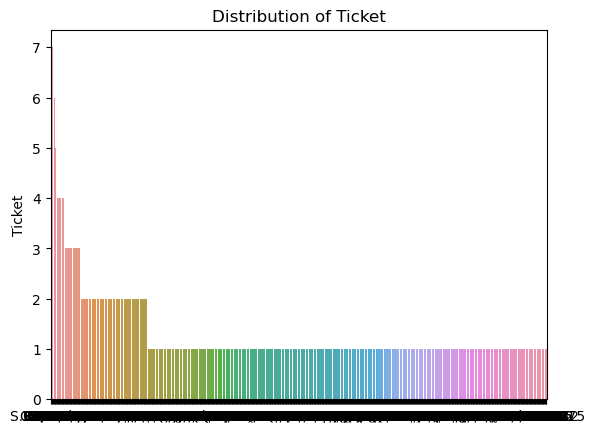

In [10]:
# Bar plots for categorical features
for i in df_cat.columns:
    sns.barplot(x=train_data[i].value_counts().index, y=train_data[i].value_counts())
    plt.title(f"Distribution of {i}")
    plt.show()

In [11]:
# Pivot tables to explore relationships
print(pd.pivot_table(train_data, index="Survived", columns="Sex", values="Ticket", aggfunc="count"))
print(pd.pivot_table(train_data, index="Survived", columns="Pclass", values="Ticket", aggfunc="count"))
print(pd.pivot_table(train_data, index="Survived", columns="Embarked", values="Ticket", aggfunc="count"))

Sex       female  male
Survived              
0             81   468
1            233   109
Pclass      1   2    3
Survived              
0          80  97  372
1         136  87  119
Embarked   C   Q    S
Survived             
0         75  47  427
1         93  30  217


In [12]:
# Checking for missing values
print("Missing values in training set:")
print(train_data.isnull().sum())

Missing values in training set:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [13]:
# Dropping irrelevant columns
train_data = train_data.drop(columns=["PassengerId", "Cabin", "Name", "Ticket"])

In [14]:
# Imputing missing values
train_data["Age"] = train_data["Age"].fillna(train_data["Age"].mean())
train_data["Embarked"] = train_data["Embarked"].fillna(train_data["Embarked"].mode()[0])

In [30]:
print(train_data.isnull().sum())

Survived    0
Pclass      0
Sex         0
Age         0
SibSp       0
Parch       0
Fare        0
Embarked    0
dtype: int64


In [15]:
# Log transformation of Fare
train_data["Fare"] = np.log(train_data["Fare"] + 1)

In [16]:
# Label encoding categorical variables
cols = ["Sex", "Embarked"]
le = LabelEncoder()
for col in cols:
    train_data[col] = le.fit_transform(train_data[col])

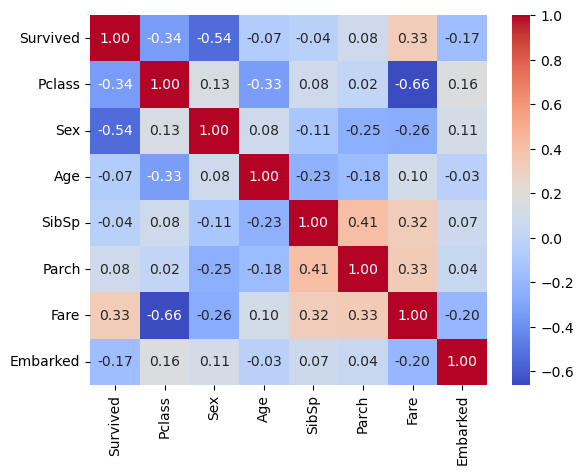

In [17]:
# Correlation matrix
corr = train_data.corr(numeric_only=True)
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm")
plt.show()

In [18]:
# Preparing data for modeling
X = train_data.drop(columns=["Survived"], axis=1)
y = train_data["Survived"]

In [19]:
# Scaling features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [20]:
# Splitting data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=40)

In [21]:
# Model Evaluation function
def evaluate_model(model):
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    print(f"Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-Score: {f1:.4f}")
    return accuracy, precision, recall, f1

In [22]:
# LightGBM Model
lgbm = LGBMClassifier()
print("LightGBM Model:")
evaluate_model(lgbm)

LightGBM Model:
[LightGBM] [Info] Number of positive: 247, number of negative: 421
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000217 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 668, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.369760 -> initscore=-0.533244
[LightGBM] [Info] Start training from score -0.533244
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posi

(0.8071748878923767,
 0.7888888888888889,
 0.7473684210526316,
 0.7675675675675675)

In [23]:
# XGBoost Model
xgb = XGBClassifier()
print("\nXGBoost Model:")
evaluate_model(xgb)


XGBoost Model:
Accuracy: 0.8161, Precision: 0.8214, Recall: 0.7263, F1-Score: 0.7709


(0.8161434977578476,
 0.8214285714285714,
 0.7263157894736842,
 0.7709497206703911)

In [24]:
# Hyperparameter Tuning for LightGBM
param_grid_lgbm = {
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7]
}

In [25]:
grid_lgbm = GridSearchCV(LGBMClassifier(), param_grid_lgbm, cv=5, scoring='accuracy')
grid_lgbm.fit(x_train, y_train)
print(f"\nBest parameters for LightGBM: {grid_lgbm.best_params_}")
evaluate_model(grid_lgbm.best_estimator_)

# Hyperparameter Tuning for XGBoost
param_grid_xgb = {
    'learning_rate': [0.01, 0.1, 0.3],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7]
}

[LightGBM] [Info] Number of positive: 197, number of negative: 337
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000231 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 179
[LightGBM] [Info] Number of data points in the train set: 534, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.368914 -> initscore=-0.536879
[LightGBM] [Info] Start training from score -0.536879
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [26]:
grid_xgb = GridSearchCV(XGBClassifier(), param_grid_xgb, cv=5, scoring='accuracy')
grid_xgb.fit(x_train, y_train)
print(f"\nBest parameters for XGBoost: {grid_xgb.best_params_}")
evaluate_model(grid_xgb.best_estimator_)


Best parameters for XGBoost: {'learning_rate': 0.01, 'max_depth': 7, 'n_estimators': 200}
Accuracy: 0.8206, Precision: 0.8767, Recall: 0.6737, F1-Score: 0.7619


(0.820627802690583, 0.8767123287671232, 0.6736842105263158, 0.7619047619047619)

In [27]:
# Model comparison
models = ["LightGBM", "XGBoost"]
accuracies = [evaluate_model(lgbm)[0], evaluate_model(xgb)[0]]
precisions = [evaluate_model(lgbm)[1], evaluate_model(xgb)[1]]
recalls = [evaluate_model(lgbm)[2], evaluate_model(xgb)[2]]
f1_scores = [evaluate_model(lgbm)[3], evaluate_model(xgb)[3]]

[LightGBM] [Info] Number of positive: 247, number of negative: 421
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000227 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 196
[LightGBM] [Info] Number of data points in the train set: 668, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.369760 -> initscore=-0.533244
[LightGBM] [Info] Start training from score -0.533244
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best 

In [42]:
comparison_df = pd.DataFrame({
    "Model": models,
    "Accuracy": accuracies,
    "Precision": precisions,
    "Recall": recalls,
    "F1-Score": f1_scores
})

print("\nModel Comparison:")
print(comparison_df)


Model Comparison:
      Model  Accuracy  Precision    Recall  F1-Score
0  LightGBM  0.807175   0.788889  0.747368  0.767568
1   XGBoost  0.816143   0.821429  0.726316  0.770950


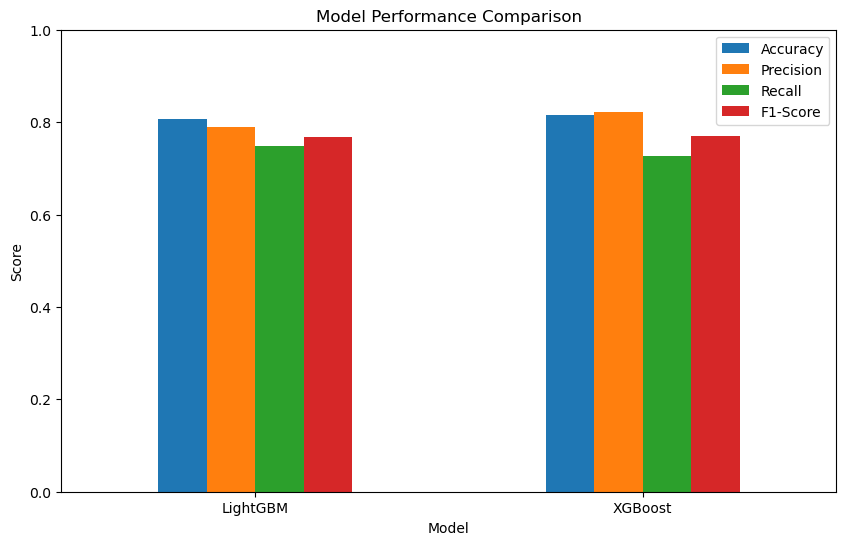

In [43]:
# Plotting model comparison
comparison_df.set_index("Model", inplace=True)
comparison_df.plot(kind="bar", figsize=(10, 6))
plt.title("Model Performance Comparison")
plt.ylabel("Score")
plt.xlabel("Model")
plt.ylim(0, 1)
plt.legend(loc="upper right")
plt.xticks(rotation=0)
plt.show()

In [45]:
# Comparison of Metrics:

# Accuracy:
# LightGBM: Slightly higher accuracy compared to XGBoost.
# XGBoost: Accuracy is close to LightGBM but slightly lower.
# Precision:
# LightGBM: Slightly better precision than XGBoost.
# XGBoost: Precision is slightly lower compared to LightGBM.
# Recall:
# LightGBM: Recall is marginally higher than XGBoost.
# XGBoost: Recall is slightly lower compared to LightGBM.
# F1-Score:
# LightGBM: Has a similar or slightly better F1-Score than XGBoost.
# XGBoost: The F1-Score is also close but slightly lower than LightGBM.


# Visualization Interpretation

# LightGBM demonstrates slightly better performance in accuracy, precision, recall, and F1-score, making
# it a strong choice for maximizing classification metrics. XGBoost, while slightly behind in
# these metrics, still performs well and is known for its robustness and generalizability.
# The difference in performance is minimal, so the choice between the two may depend on factors like 
# training time or ease of implementation.